- (c) Ken-ichi Fukui, 2025/01/05
- MIT License

## 線形回帰によるHousingデータ住宅価格の推定と特徴選択

In [21]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### California Housingデータのロード

In [16]:
housing = fetch_california_housing()
X = scale(housing.data)
y = housing.target
n_of_features = len(housing.feature_names)

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

### 線形回帰＋逐次前進特徴選択（SBS）

In [17]:
r2_trn_ave, r2_tst_ave = [], []

for n_features in range(1, 8):
    lr = LinearRegression()
    sfs_forward = SequentialFeatureSelector(lr,
                                            scoring = 'r2',
                                            direction='forward',
                                            n_features_to_select=n_features,
                                            cv=5)
    sfs_forward.fit(X, y)
    print("Selected feature names:", sfs_forward.get_feature_names_out(housing.feature_names))

    X_selected = sfs_forward.transform(X)
    lr_selected = LinearRegression()
    scores = cross_validate(lr_selected, X_selected, y, cv=10, return_train_score=True)
    r2_trn_ave.append(scores['train_score'].mean())
    r2_tst_ave.append(scores['test_score'].mean())

Selected feature names: ['MedInc']
Selected feature names: ['MedInc' 'HouseAge']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude']


### 特徴数毎の平均決定係数のグラフをプロット

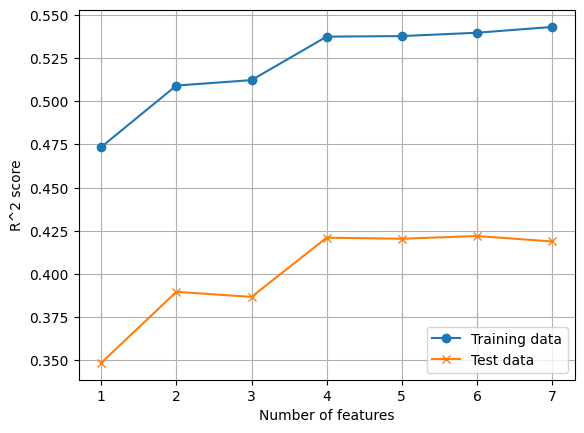

In [19]:
plt.plot(range(1,8), r2_trn_ave, marker='o', label="Training data")
plt.plot(range(1,8), r2_tst_ave, marker='x', label="Test data")
plt.ylabel('R^2 score')
plt.xlabel('Number of features')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Lasso回帰

In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}

n_of_trials=30
tst_scores_lasso, n_features= [],[]
for k in range(0, n_of_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)
    gs = GridSearchCV(Lasso(), params, cv=3, scoring="r2")
    gs.fit(X_train, y_train)
    print("#{:2d} best validation score:{:.3f}, best param:{}".format(k+1, gs.best_score_, gs.best_params_))

    # ベストパラメータで再学習しテストデータに適用
    lasso = Lasso(alpha=gs.best_params_['alpha'])
    lasso.fit(X_train, y_train)
    tst_scores_lasso.append(lasso.score(X_test, y_test))
    n_features.append(np.count_nonzero(lasso.coef_))

# 1 best validation score:0.607, best param:{'alpha': 0.001}
# 2 best validation score:0.605, best param:{'alpha': 0.001}
# 3 best validation score:0.600, best param:{'alpha': 0.01}
# 4 best validation score:0.605, best param:{'alpha': 0.001}
# 5 best validation score:0.603, best param:{'alpha': 0.001}
# 6 best validation score:0.600, best param:{'alpha': 0.001}
# 7 best validation score:0.602, best param:{'alpha': 0.001}
# 8 best validation score:0.591, best param:{'alpha': 0.01}
# 9 best validation score:0.600, best param:{'alpha': 0.001}
#10 best validation score:0.610, best param:{'alpha': 0.001}
#11 best validation score:0.596, best param:{'alpha': 0.01}
#12 best validation score:0.601, best param:{'alpha': 0.001}
#13 best validation score:0.600, best param:{'alpha': 0.001}
#14 best validation score:0.605, best param:{'alpha': 0.001}
#15 best validation score:0.600, best param:{'alpha': 0.01}
#16 best validation score:0.605, best param:{'alpha': 0.001}
#17 best validation score:0.

In [28]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}

gs = GridSearchCV(Lasso(), params, cv=5, scoring="r2")
gs.fit(X, y)
print("best validation score:{:.3f}, best param:{}".format(gs.best_score_, gs.best_params_))

# ベストパラメータで再学習しテストデータに適用
lasso_best = Lasso(alpha=gs.best_params_['alpha'])
scores = cross_validate(lasso_best, X, y, cv=10, return_train_score=True)
print(scores['train_score'].mean())
print(scores['test_score'].mean())

#best validation score:0.553, best param:{'alpha': 0.001}
0.6063370598244259
0.5114670870740959


In [24]:
print("Ave. test accuracy: {:.3f}".format(np.mean(tst_scores_lasso)))
print("Ave. number of features: {:.3f}".format(np.mean(n_features)))

Ave. test accuracy: 0.594
Ave. number of features: 7.333


### SVR

In [ ]:
from sklearn.svm import SVR

params = {'gamma':[0.01, 0.05, 0.1], 'epsilon':[0.01, 0.1, 1.0], 'C':[10.0, 100.0, 1000.0]}

tst_scores_svr= []
for k in range(0, n_of_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)
    gs = GridSearchCV(SVR(kernel='rbf'), params, cv=3, scoring="r2")
    gs.fit(X_train, y_train)
    print("#{:2d} best validation score:{:.3f}, best param:{}".format(k+1, gs.best_score_, gs.best_params_))

    # ベストパラメータで再学習しテストデータに適用
    svr = SVR(kernel='rbf', gamma=gs.best_params_['gamma'], epsilon=gs.best_params_['epsilon'], C=gs.best_params_['C'])
    svr.fit(X_train, y_train)
    tst_scores_svr.append(svr.score(X_test, y_test))

In [ ]:
print("Ave. test accuracy: {:.3f}".format(np.mean(tst_scores_svr)))

Ave. test accuracy: 0.841
